# AVISO data in zarr

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
from m2lib22.cstes import labels, zarr_dir

- i=0,1 :  jobs=6, cores = 26 
- i=2,3 :  jobs=1, cores = 26 
- i=4 :    jobs=1, cores = 10
- i=5 :    jobs=1, cores = 26
- i=6 :    jobs=4, cores = 26

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=26, processes=26, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.38:8787/status,
Dashboard: http://10.148.0.38:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.38:59920,Workers: 0
Dashboard: http://10.148.0.38:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### Test 

In [3]:
i=3
l=labels[i]
ds_data = xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr')
ds_data = ds_data.chunk({'obs':500, 'alti_time':-1, 'site_obs':-1}).persist()
print('1')

1


In [20]:
ds_data

<xarray.Dataset>
Dimensions:                        (obs: 12077, alti_time: 21,
                                    alti_time_mid: 20, box_y: 40, box_x: 80,
                                    site_obs: 1489)
Coordinates: (12/19)
    alti_lat                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    alti_lon                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (obs, alti_time) datetime64[ns] dask.array<chunksize=(500, 21), meta=np.ndarray>
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    ...                             ...
    drifter_time                   (obs, site_obs) datetime64[ns] dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_x                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                           (obs) datetime64[ns] dask.array<chunksize=(500,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs
Data variables: (12/61)
    __site_id                      (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    __site_matchup_indice          (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                    (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    alti___distance                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source                  (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source_center_index     (obs) object dask.array<chunksize=(500,), meta=np.ndarray>
    ...                             ...
    drifter_typedeath              (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_ve                     (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vn                     (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__argos
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [4]:
ds_aviso = aviso.compute_aviso_sla(ds_data).persist()
print('2')

2


In [5]:
ds_aviso

<xarray.Dataset>
Dimensions:                             (box_x: 80, box_y: 40, obs: 74235,
                                         site_obs: 1489, aviso_time: 3)
Coordinates:
  * box_x                               (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                               (box_y) float64 -1e+05 ... 9.5e+04
    aviso_time_                         (obs, aviso_time) datetime64[ns] dask.array<chunksize=(500, 3), meta=np.ndarray>
    time                                (obs) datetime64[ns] dask.array<chunksize=(500,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, aviso_time
Data variables: (12/31)
    aviso_traj_sla                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_err_sla                  (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_adt                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                        (obs, site_obs) datetime64[ns] dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_x                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    ...                                  ...
    aviso_alti_matchup_err_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

In [5]:
zarr = os.path.join(zarr_dir, "aviso_"+l+".zarr")
print('3')
ds_aviso.to_zarr(zarr, mode="w")
print(f"aviso {l} storred in {zarr}")

3
aviso argos_SASSA_Sentinel_2018 storred in /home1/datawork/mdemol/m2/aviso_argos_SASSA_Sentinel_2018.zarr


## Open Test

In [3]:
i=1
l=labels[i]
ds_aviso_test = xr.open_zarr(cstes.zarr_dir+'/aviso_'+l+'.zarr').persist()

In [4]:
ds_aviso_test

<xarray.Dataset>
Dimensions:                             (obs: 73334, box_y: 40, box_x: 80,
                                         aviso_time: 3, site_obs: 1489)
Coordinates:
    aviso_time_                         (obs, aviso_time) datetime64[ns] dask.array<chunksize=(18334, 2), meta=np.ndarray>
  * box_x                               (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                               (box_y) float64 -1e+05 ... 9.5e+04
    time                                (obs) datetime64[ns] dask.array<chunksize=(36667,), meta=np.ndarray>
Dimensions without coordinates: obs, aviso_time, site_obs
Data variables: (12/31)
    aviso_alti_matchup_adt              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_err_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                  ...
    aviso_traj_g_grad_x                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_g_grad_y                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_sla                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                        (obs, site_obs) datetime64[ns] dask.array<chunksize=(2292, 94), meta=np.ndarray>
    drifter_x                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

In [5]:
ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name']=ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name'].replace(' matchup', 'matchup')

In [6]:
ds_aviso_test.aviso_drifter_matchup_g_grad_x.attrs['long_name']

'$g\\partial_x\\eta_{driftermatchup}$'

#pb attrs
i=6
l=labels[i]
ds_aviso_test = xr.open_zarr(cstes.zarr_dir+'/aviso_'+l+'.zarr').persist()
for v in ds_aviso_test:
     if 'matchup' in v:
            ds_aviso_test[v].attrs['long_name']=ds_aviso_test[v].attrs['long_name'].replace(' matchup', 'matchup')
zarr = os.path.join(zarr_dir, "aviso_"+l+".zarr")
ds_aviso_test.to_zarr(zarr, mode="w")
print(f"aviso {l} storred in {zarr}")

In [11]:
ds_aviso_test

<xarray.Dataset>
Dimensions:                             (obs: 73334, box_y: 40, box_x: 80,
                                         aviso_time: 3, site_obs: 1489)
Coordinates:
    aviso_time_                         (obs, aviso_time) datetime64[ns] dask.array<chunksize=(18334, 2), meta=np.ndarray>
  * box_x                               (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                               (box_y) float64 -1e+05 ... 9.5e+04
    time                                (obs) datetime64[ns] dask.array<chunksize=(36667,), meta=np.ndarray>
Dimensions without coordinates: obs, aviso_time, site_obs
Data variables: (12/31)
    aviso_alti_matchup_adt              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_adt_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_err_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                  ...
    aviso_traj_g_grad_x                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_g_grad_y                 (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_sla                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                        (obs, site_obs) datetime64[ns] dask.array<chunksize=(2292, 94), meta=np.ndarray>
    drifter_x                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                           (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

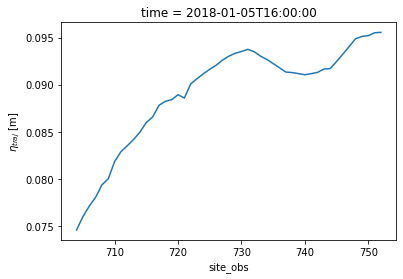

In [9]:
ds_aviso_test.isel(obs=0).aviso_traj_sla.plot()

In [10]:
ds_aviso_test

<xarray.Dataset>
Dimensions:                         (obs: 12077, box_y: 40, box_x: 80,
                                     aviso_time: 3, site_obs: 1489)
Coordinates:
    aviso_time_                     (obs, aviso_time) datetime64[ns] dask.array<chunksize=(6039, 3), meta=np.ndarray>
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
    time                            (obs) datetime64[ns] dask.array<chunksize=(12077,), meta=np.ndarray>
Dimensions without coordinates: obs, aviso_time, site_obs
Data variables: (12/19)
    aviso_alti_matchup_err_sla      (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_x     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_g_grad_y     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_matchup_sla          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_box_err_sla               (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    aviso_box_g_grad_x              (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    ...                              ...
    aviso_traj_g_grad_x             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_g_grad_y             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    aviso_traj_sla                  (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time                    (obs, site_obs) datetime64[ns] dask.array<chunksize=(755, 187), meta=np.ndarray>
    drifter_x                       (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                       (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...

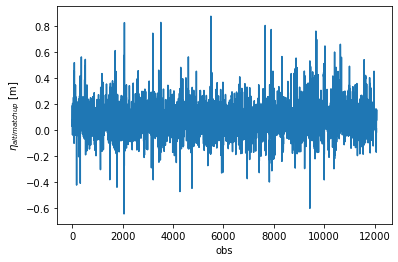

In [11]:
ds_aviso_test.aviso_alti_matchup_sla.plot()

In [6]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
